# Causal inference & discovery

Example based on:

Molak, A. Causal inference and discovery in Python: machine learning and Pearlian perspective: unlock the secrets of modern causal machine learning with DoWhy, EconML, PyTorch and more. (No Title).

In [ ]:
!pip install dowhy
!pip install gcastle
!pip install econml
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from dowhy import CausalModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import clear_output

In [8]:
np.random.seed(0)

# 1. Synthetic generation

In [4]:
# Target: Y
# Treatment: X

SAMPLE_SIZE = 1000
S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)
df = pd.DataFrame(
    {
        'S': S,
        'Q': Q,
        'X': X,
        'Y': Y,
        'P': P,
    }
    )
df.head(5)

,S,Q,X,Y,P
0,0.548814,0.506992,0.395586,0.607651,0.362090
1,0.715189,0.149781,0.211403,0.544427,0.329867
2,0.602763,0.439356,0.270772,0.617614,0.276362
3,0.544883,0.583853,0.181948,0.570324,0.274942
4,0.423655,0.114194,0.258004,0.524673,0.232831


In [ ]:
'''
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])
df.head(5)
'''

"\ndf = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])\ndf.head(5)\n"

# 2. Baseline - Linear Regression

In [ ]:
Y = df['Y']
X = df[['S', 'P', 'Q', 'X']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [ ]:
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1080.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:36:41   Log-Likelihood:                 1292.9
No. Observations:                1000   AIC:                            -2576.
Df Residuals:                     995   BIC:                            -2551.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0799      0.008      9.905      0.000       0.064       0.096
S              0.2979      0.008     37.817      0.000       0.282       0.313
P              0.2652      0.033      8.053      0.000       0.201       0.330
Q              0.0927      0.011      8.524      0.000       0.071       0.114
X              0.5785      0.026     22.184      0.000       0.527       0.630
==============================================================================
Omnibus:                      277.966   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.703
Skew:                           0.072   Prob(JB):                     7.22e-11
Kurtosis:                       1.951   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
print(results.params)

const    0.079882
S        0.297857
P        0.265168
Q        0.092702
X        0.578534
dtype: float64


# 3. Causal Inference Model

In [5]:
# 1. Encode assumptions
nodes = ['S', 'Q', 'X', 'Y', 'P']
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
gml_string = 'graph [directed 1\n'
for node in nodes:
  gml_string += f'\tnode [id "{node}" label "{node}"]\n'
for edge in edges:
  gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
gml_string += "]"
print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


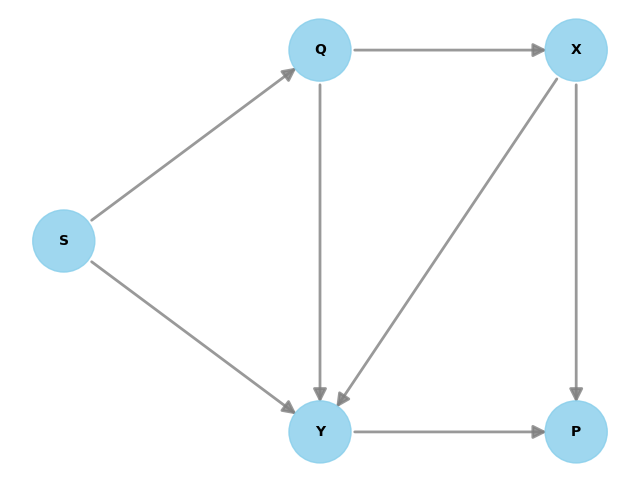

In [17]:
# Instantiate model
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)
model.view_model()

In [18]:
# 2. Getting the estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
# 3. Getting the estimate
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False)
        },
        'fit_params':{}
    }
)
print(estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

## Realized estimand
b: Y~X+Q | 
Target units: ate

## Estimate
Mean value: 0.712501264272969
Effect estimates: [[0.71250126]]



In [ ]:
print(f"Estimate of causal effect (DML): {estimate.value}")

Estimate of causal effect (DML): 0.6857252951405622


In [ ]:
'''
# 3. Getting the estimate (alternative version - simpler models)
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')
'''

'\n# 3. Getting the estimate (alternative version - simpler models)\nestimate_lr = model.estimate_effect(\n    identified_estimand=estimand,\n    method_name=\'backdoor.linear_regresssion\'\n)\nprint(f"Estimate of causal effect (Linear Regression): {estimate_lr.value}")\n'

In [ ]:
# Tests
random_cause = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause'
)
clear_output()
print(random_cause)

Refute: Add a random common cause
Estimated effect:0.6857252951405622
New effect:0.6861760077816318
p value:0.96



In [ ]:
placebo_refuter = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='placebo_treatment_refuter'

)
clear_output()
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.6857252951405622
New effect:0.0
p value:1.0



In [ ]:
# Estimating with Confidence Intervals -> Revisar!
# Source: https://www.pywhy.org/dowhy/v0.5.1/example_notebooks/dowhy-conditional-treatment-effects.html
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    confidence_intervals=True,
    target_units = "ate",
    method_params={"init_params":{
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False)
            },
                    "fit_params":{
                        'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                        }
                    }
    )
clear_output()
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

## Realized estimand
b: Y~X+Q | 
Target units: ate

## Estimate
Mean value: 0.6879509475770892
Effect estimates: [[0.68795095]]
95.0% confidence interval: [[[0.63773648]]

 [[0.75100473]]]



In [ ]:
# Getting predictions -> REVISAR!
df_test = df.copy()

dml_estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    target_units = df_test,
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False)
        },
        'fit_params':{}
    }
)
clear_output()
print(dml_estimate.cate_estimates)

[[0.73056663]]


In [ ]:
df_test

,S,Q,X,Y,P
0,0.548814,0.506992,0.395586,0.607651,0.362090
1,0.715189,0.149781,0.211403,0.544427,0.329867
2,0.602763,0.439356,0.270772,0.617614,0.276362
3,0.544883,0.583853,0.181948,0.570324,0.274942
4,0.423655,0.114194,0.258004,0.524673,0.232831
...,...,...,...,...,...
995,0.097676,0.549694,0.453632,0.493179,0.346624
996,0.514922,0.586187,0.300519,0.543989,0.295261
997,0.938412,0.509355,0.200755,0.696050,0.275921
998,0.228647,0.477118,0.392215,0.624074,0.387419


# 4. GCM API

In [ ]:
import networkx as nx
from dowhy import gcm

In [ ]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [ ]:
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

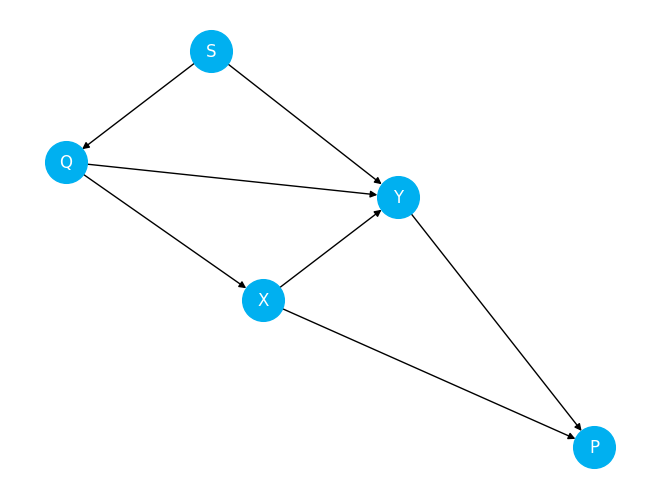

In [ ]:
nx.draw(
    graph_nx,
    with_labels=True,
    node_size=900,
    font_color='white',
    node_color=COLORS[0]
)

In [ ]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

In [ ]:
causal_model.set_causal_mechanism('S', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('P', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Q', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node P: 100%|██████████| 5/5 [00:00<00:00, 51.41it/s]


In [ ]:
# Get arrow strength
# By default, arrow_strength employs KL divergence for measuring the arrow strength for categorical target
# Results in terms of the ouctome variable variance chnage given we remove the edge from the source variable
gcm.arrow_strength(causal_model, 'Y')

{('Q', 'Y'): 0.00046328184101239385,
 ('S', 'Y'): 0.008028641805887254,
 ('X', 'Y'): 0.007329338898069036}

In [ ]:
# Generate counterfactual samples (I)
gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: .21},
    observed_data=pd.DataFrame(data=dict(X=[.5], Y=[.75], S=[.5], Q=[.4], P=[.34])))

,S,Q,X,Y,P
0,0.5,0.4,0.21,0.546308,0.16978


In [ ]:
# Generate counterfactual samples (II) - coeff X
original_Y = .75
df = gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: 1},
    observed_data=pd.DataFrame(data=dict(X=[2], Y=[original_Y], S=[.5], Q=[.4], P=[.34])))
display(df)
print(f"Coeff X: {np.abs(original_Y - df['Y'].values[0])}")

,S,Q,X,Y,P
0,0.5,0.4,1,0.047614,-0.246964


Coeff X: 0.7023855377507204


In [ ]:
# Generate counterfactual samples (II) - coeff S
original_Y = .75
df = gcm.counterfactual_samples(
    causal_model,
    {'S': lambda x: 1},
    observed_data=pd.DataFrame(data=dict(X=[0.5], Y=[original_Y], S=[2], Q=[.4], P=[.34])))
display(df)
print(f"Coeff S: {np.abs(original_Y - df['Y'].values[0])}")

,S,Q,X,Y,P
0,1,0.228772,0.478041,0.404159,0.263589


Coeff S: 0.34584132647511545


In [ ]:
#def mean_diff(Y_old, Y_new): return np.mean(Y_new) - np.mean(Y_old)
#gcm.arrow_strength(causal_model, 'Y', difference_estimation_func=mean_diff)

{('Q', 'Y'): 0.000647831459594639,
 ('S', 'Y'): 0.009415088570715945,
 ('X', 'Y'): -0.0012906230284506347}

In [ ]:
# TODO: Expresarlo como coefficientes análogos a los de regresión

# 5. Causal Inference - Otros modelos

In [ ]:
import shap

from econml.dml import CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV, LassoCV
from econml.dr import LinearDRLearner
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

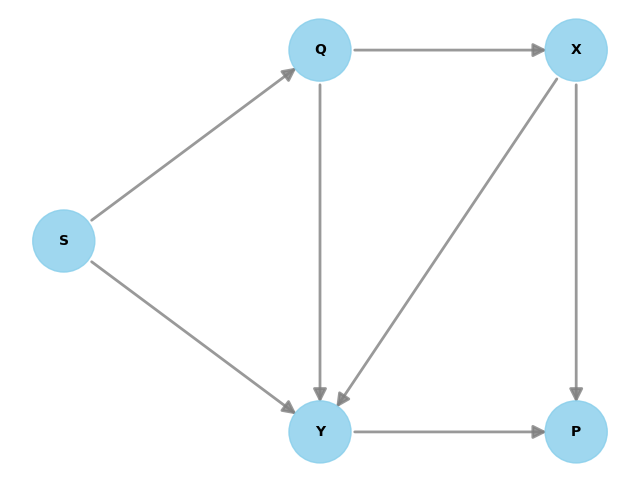

In [ ]:
# Instantiate model
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)
model.view_model()

In [ ]:
# 2. Getting the estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
# 3. Getting the estimate
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(),
            'model_t': LGBMRegressor(),
            'model_final': LassoCV(fit_intercept=False)
        },
        'fit_params':{}
    }
)

In [ ]:
print(f"Estimate of causal effect (DML): {estimate.value}")

Estimate of causal effect (DML): 0.6969388496310024


In [ ]:
# Based on: https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7

# set parameters for causal forest
causal_forest = CausalForestDML(
    criterion='het',
    n_estimators=500,
    min_samples_leaf=10,
    max_depth=None,
    max_samples=0.5,
    discrete_treatment=False,
    honest=True,
    inference=True,
    cv=10,
    model_t=LassoCV(),
    model_y=LassoCV(),
    )

# split data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers

Y_outcome = df_train['Y']
T_treatment = df_train['X']
X_covariates = df_train[['P', 'Q', 'S']]
W = None

X_covariates_test = df_test[['P', 'Q', 'S']]

# fit train data to causal forest model
causal_forest.fit(Y_outcome, T_treatment, X=X_covariates, W=W)

# estimate the CATE with the test set
causal_forest.const_marginal_ate(X_covariates_test)

0.580112725560671

In [ ]:
'''
# calculate shap values of causal forest model
shap_values = causal_forest.shap_values(X_covariates)
# plot shap values
shap.summary_plot(shap_values['Y0']['T0'])
'''

"\n# calculate shap values of causal forest model \nshap_values = causal_forest.shap_values(X_covariates)\n# plot shap values \nshap.summary_plot(shap_values['Y0']['T0'])\n"

# 6. Causal Discovery

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict
from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

In [ ]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [ ]:
# Instantiate the model
pc = PC()

In [ ]:
# Fit the model
pc.learn(df)

In [ ]:
pred_dag = pc.causal_matrix
pred_dag

Tensor([[0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0]])

In [ ]:
print("Legend:")
i = 0
for column in df.columns:
  print(f"{column} -> col {i}")
  i += 1

Legend:
S -> col 0
Q -> col 1
X -> col 2
Y -> col 3
P -> col 4


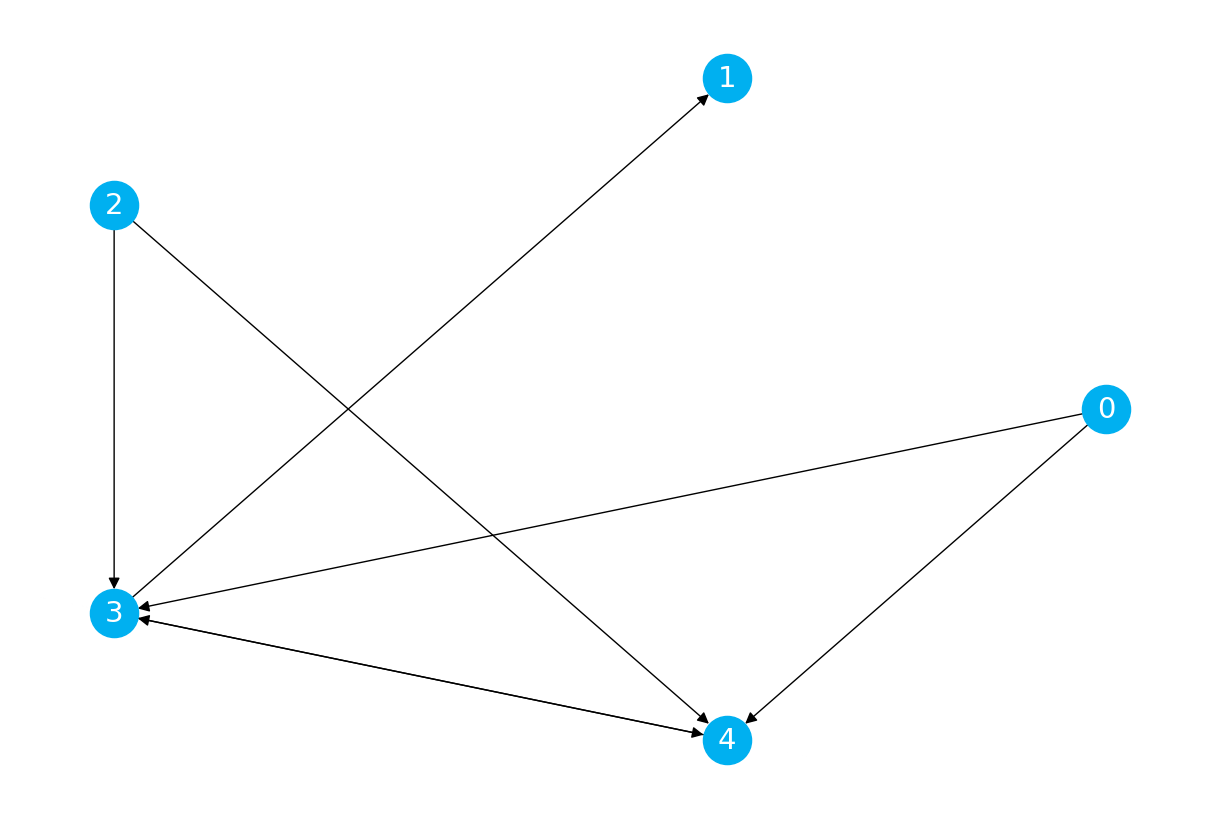

In [ ]:
g_pred = nx.DiGraph(pred_dag)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g_pred,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g_pred)
)

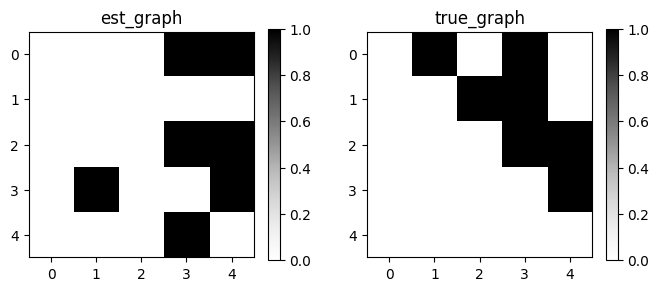

In [ ]:
# Evaluation
#true_dag = nx.adjacency_matrix(graph_nx).todense() # WARNING -> this does not ensure the same node order

# Build the True DAG adj matrix
true_dag = np.array([
    [0, 1, 0, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]
])

GraphDAG(
    est_dag=pc.causal_matrix,
    true_dag=true_dag
)
plt.show()

In [ ]:
MetricsDAG(
    B_est=pc.causal_matrix,
    B_true=true_dag
).metrics

{'fdr': 0.3333,
 'tpr': 0.5714,
 'fpr': 0.6667,
 'shd': 4,
 'nnz': 6,
 'precision': 0.5714,
 'recall': 0.5714,
 'F1': 0.5714,
 'gscore': 0.1429}

In [ ]:
true_dag

array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

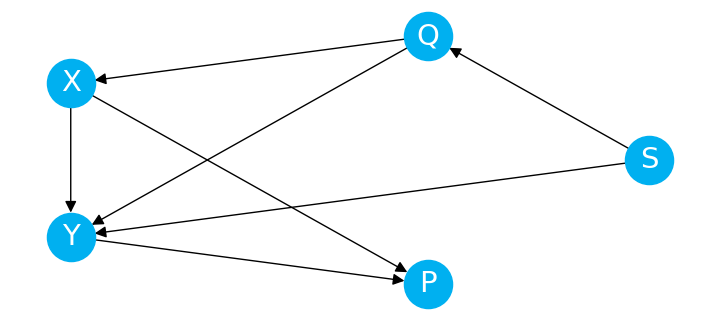

In [ ]:
# Check matrix

# Get learned graph
true_graph = nx.DiGraph(true_dag)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(5), ['S', 'Q', 'X', 'Y', 'P'])}
true_graph = nx.relabel_nodes(true_graph, MAPPING, copy=True)

plt.figure(figsize=(7, 3))
nx.draw(
    G=true_graph,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(true_graph)
)

In [ ]:
def get_n_undirected(g):

    total = 0

    for i in range(g.shape[0]):
        for j in range(g.shape[0]):
            if (g[i, j] == 1) and (g[i, j] == g[j, i]):
                total += .5

    return total

Method: PC


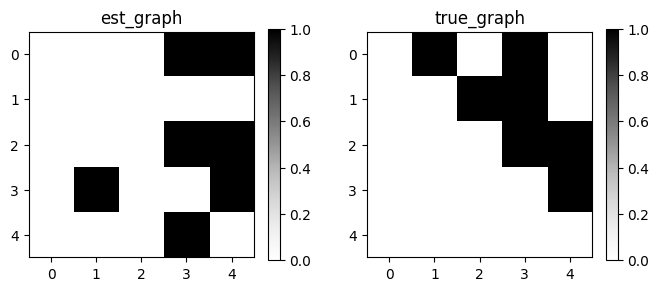

FDR: 0.3333
Recall: 0.5714
Precision: 0.5714
F1 score: 0.5714
SHD score: 4
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


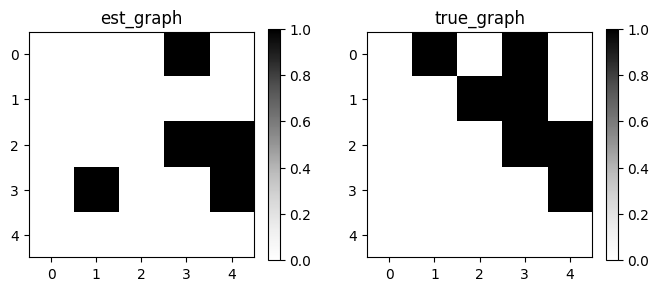

FDR: 0.2
Recall: 0.5714
Precision: 0.8
F1 score: 0.6667
SHD score: 3
No. of undir. edges: 0

-------------------------------------------------- 

Method: LiNGAM


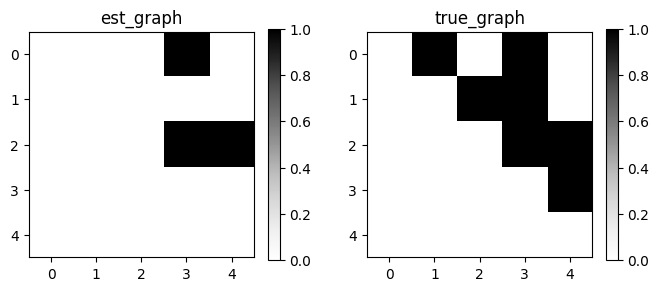

FDR: 0.0
Recall: 0.4286
Precision: 1.0
F1 score: 0.6
SHD score: 4
No. of undir. edges: 0

-------------------------------------------------- 

Method: Notears


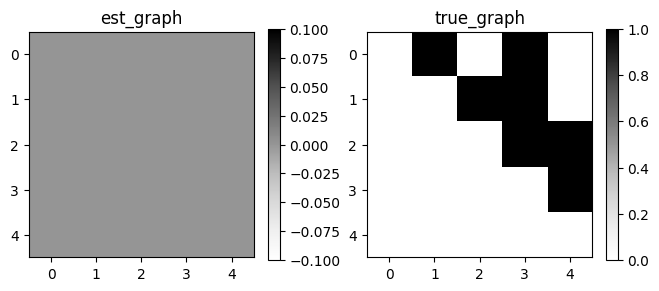

invalid value encountered in long_scalars


FDR: 0.0
Recall: 0.0
Precision: nan
F1 score: nan
SHD score: 7
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


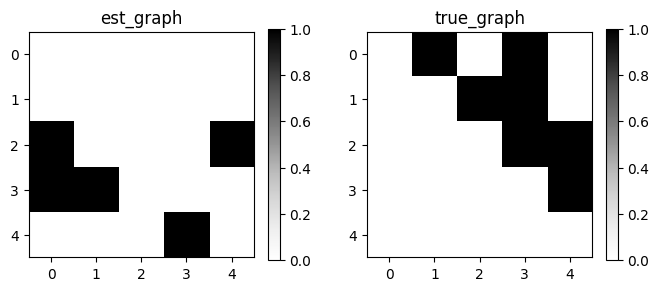

FDR: 0.8
Recall: 0.1429
Precision: 0.2
F1 score: 0.1667
SHD score: 7
No. of undir. edges: 0

-------------------------------------------------- 





In [ ]:
# Try several methods

# Pick the methods
methods = OrderedDict({
    'PC': PC,
    'GES': GES,
    'LiNGAM': DirectLiNGAM,
    'Notears': NotearsNonlinear,
    'GOLEM': GOLEM
})

results = {}
for method in methods:

    print(f'Method: {method}')

    # Fit the model
    if method == 'GOLEM':
        model = methods[method](num_iter=2.5e4)
    else:
        model = methods[method]()

    # Fit the model
    model.learn(df)

    # Get the DAG
    pred_dag = model.causal_matrix

    # Get n undir edges
    n_undir = get_n_undirected(pred_dag)

    # Plot results
    GraphDAG(pred_dag, true_dag, 'result')

    mt = MetricsDAG(pred_dag, true_dag)
    print(f'FDR: {mt.metrics["fdr"]}')
    print(f'Recall: {mt.metrics["recall"]}')
    print(f'Precision: {mt.metrics["precision"]}')
    print(f'F1 score: {mt.metrics["F1"]}')
    print(f'SHD score: {mt.metrics["shd"]}')
    print(f'No. of undir. edges: {n_undir}\n')
    print('-' * 50, '\n')

    results[method] = pred_dag

print('\n')

In [ ]:
df

,S,Q,X,Y,P
0,0.548814,0.506992,0.395586,0.607651,0.362090
1,0.715189,0.149781,0.211403,0.544427,0.329867
2,0.602763,0.439356,0.270772,0.617614,0.276362
3,0.544883,0.583853,0.181948,0.570324,0.274942
4,0.423655,0.114194,0.258004,0.524673,0.232831
...,...,...,...,...,...
995,0.097676,0.549694,0.453632,0.493179,0.346624
996,0.514922,0.586187,0.300519,0.543989,0.295261
997,0.938412,0.509355,0.200755,0.696050,0.275921
998,0.228647,0.477118,0.392215,0.624074,0.387419
